In [ ]:
# default_exp fastai-sequence

# Action Recognition using Fastai

> Ref. [3D Resnet for NIfTI images](https://gist.github.com/jcreinhold/78943cdeca1c5fca4a5af5d066bd8a8d)

In [ ]:
import cv2
from PIL import Image

import fastai
from fastai.vision import *
from fastai.vision.transform import *
import torchvision.transforms as transforms

from fastai.metrics import error_rate, accuracy

from actions_in_videos.dataset_ucf101 import UCF101
from actions_in_videos.avi import AVI
from actions_in_videos.models_resnet_3d import resnet50

Reload packages where content for package development

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
print(f'fastai version: {fastai.__version__}')
print(f'pytorch version: {torch.__version__}')
print('python version: {}.{}.{}'.format(sys.version_info.major, sys.version_info.minor, sys.version_info.micro))
#print(f'torchvision version: {torchvision.__version__}')

fastai version: 1.0.60
pytorch version: 1.3.0
python version: 3.6.9


Check GPU

In [ ]:
!nvidia-smi

## Custom DataSets in Fastai
> ref. https://docs.fast.ai/basic_data.html#DataBunch  
https://docs.fast.ai/tutorial.itemlist.html  
https://blog.usejournal.com/finding-data-block-nirvana-a-journey-through-the-fastai-data-block-api-c38210537fe4  

In [ ]:
class SingleFrameList(ItemList): 
    """
       Subclass ImageList to use our own image opening function
       This is the main class that allows you to group your inputs or your targets in the data block API. 
       You can then use any of the splitting or labelling methods before creating a DataBunch."""
    # _bunch
    # _processor
    _label_cls=None  # If set to one, fastai selects one class that should fit.
    def __init__(self, items, **kwargs):
        super().__init__(items, **kwargs)        
      
    def open(self, fn:PathOrStr)->Image:
        avi = AVI(fn, verbose=True, img_type=np.float32)
        x = avi.getRandomFrame()        
        # This ndarray image has to be converted to tensor before passing on as fastai Image, we can use pil2tensor
        x = pil2tensor(x,np.float32)
        x.div_(255)            
        return vision.Image(x)    
    
    def get(self, i):
        "Defines how to construct an ItemBase from the data in the ItemList.items array"
        fn = super().get(i)
        res = self.open(fn)
        return res
    
    def reconstruct(self, t:Tensor): 
        return vision.Image(t.float().clamp(min=0,max=1))
    
    @classmethod
    def from_folder(cls, path, **kwargs):
        res = super().from_folder(path, **kwargs)
        res.path = path
        return res
    
    def split_by_files(self, names):
        return self.split_by_valid_func(lambda o: any(o.name in vn for vn in names))
    
    def split_by_fname_file(self, fname, path=None, **kwargs):        
        "Split the data by using the names in `fname` for the validation set. `path` will override `self.path`."        
        path = Path(ifnone(path, self.path))
        relative_valid_names = loadtxt_str(path/fname)
        valid_names = [str(Path(self.path).joinpath(Path(fn))) for fn in relative_valid_names]        
        return self.split_by_files(valid_names)        
    
    def show_xys(self, xs, ys, imgsize:int=4, figsize:Optional[Tuple[int,int]]=None, **kwargs):
        "Show the `xs` (inputs) and `ys` (targets) on a figure of `figsize`."
        rows = int(np.ceil(math.sqrt(len(xs))))
        axs = subplots(rows, rows, imgsize=imgsize, figsize=figsize)
        for x,y,ax in zip(xs, ys, axs.flatten()): x.show(ax=ax, y=y, **kwargs)
        for ax in axs.flatten()[len(xs):]: ax.axis('off')
        plt.tight_layout()

    def show_xyzs(self, xs, ys, zs, imgsize:int=4, figsize:Optional[Tuple[int,int]]=None, **kwargs):
        "Show `xs` (inputs), `ys` (targets) and `zs` (predictions) on a figure of `figsize`."
        if self._square_show_res:
            title = 'Ground truth\nPredictions'
            rows = int(np.ceil(math.sqrt(len(xs))))
            axs = subplots(rows, rows, imgsize=imgsize, figsize=figsize, title=title, weight='bold', size=12)
            for x,y,z,ax in zip(xs,ys,zs,axs.flatten()): x.show(ax=ax, title=f'{str(y)}\n{str(z)}', **kwargs)
            for ax in axs.flatten()[len(xs):]: ax.axis('off')
        else:
            title = 'Ground truth/Predictions'
            axs = subplots(len(xs), 2, imgsize=imgsize, figsize=figsize, title=title, weight='bold', size=14)
            for i,(x,y,z) in enumerate(zip(xs,ys,zs)):
                x.show(ax=axs[i,0], y=y, **kwargs)
                x.show(ax=axs[i,1], y=z, **kwargs)

In [ ]:
data = (SingleFrameList.from_folder('../data/UCF101/UCF-101/'))

In [ ]:
data.items

In [ ]:
def get_y_func(o):
    if str(o.parents[0]).split('/')[-1] == 'models':
        print(str(o.parents[0]).split('/')[-1]) 
    return str(o.parents[0]).split('/')[-1]

get_y = lambda o:str(o.parents[0]).split('/')[-1]

tfms = get_transforms(do_flip=True, flip_vert=False)

data_path = '../data/UCF101/UCF-101/'

In [ ]:
data = (SingleFrameList.from_folder(data_path) # Where to find the data? -> in path and its subfolders
        .split_by_fname_file(fname='testlist01.txt', path='../data/UCF101/annotations/ucfTrainTestlist/')             #How to split in train/valid? -> use the folders
        .label_from_func(get_y_func)         # How to label
#        .add_test_folder()                  # Optionally add a test set (here default name is test)
        .transform(tfms, size=224)           # Data augmentation? -> use tfms with a size of 224
        .databunch())    

In [ ]:
data.show_batch()

In [ ]:
len(data.train_ds.y.classes)

## Using a default fastai cnn learner

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=[error_rate, accuracy])

In [ ]:
learn.path

In [ ]:
learn.model_dir = '../../../actions_in_videos/models'

## Training

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1,1e-2)

In [ ]:
learn.save('fastai-1')

In [ ]:
learn.fit_one_cycle(10,1e-2)

In [ ]:
learn.fit_one_cycle(5,1e-2)

In [ ]:
learn.fit_one_cycle(5,1e-2)

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(3,1e-2)

In [ ]:
learn.fit_one_cycle(10,1e-2)

In [ ]:
learn.save('fastai-3', return_path=True)

In [ ]:
learn.load('fastai-3')

In [ ]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)

In [ ]:
interp.plot_confusion_matrix(figsize=(20,20), dpi=60)

In [ ]:
interp.plot_top_losses(9, figsize=(20,20), heatmap=True)

# Conv3D

In [ ]:
def sequence2np(seq:Tensor)->np.ndarray:
    "Convert from torch style `sequence` to numpy/matplotlib style."
    #set_trace()    # run: x = seq.view(batch_size * seq_length, -1)
    # reshape to have the seq as a single bigger image.
    seq = seq.reshape(1,3,seq.shape[0]*seq.shape[2],-1)     
    res = seq.cpu().permute(0,2,3,1).numpy().squeeze()  
    return res[...,0] if res.shape[2]==1 else res

In [ ]:
class Sequence(ItemBase): 
    """ Support applying transforms to sequence data (tensor of images) in `px`.        
        As all ItemBase classes, it is not usable until you have put it inside your custom ItemList though.        
        """
    def __init__(self, px:Tensor):
        self._obj = px # this is the original data.
        self._px  = px # this is the property that gets changed.
        self._seq_len = self._px.shape[0]
        
    def clone(self):
        "Mimic the behavior of torch.clone for `Sequence` objects."
        return self.__class__(self.px.clone())
     
    @property
    def shape(self)->Tuple[int,int,int,int]: return self._px.shape
    @property
    def size(self)->Tuple[int,int,int]: return self.shape[-2:]
    @property
    def device(self)->torch.device: return self._px.device
    
    def __len__(self):
        return len(self._px[0])
    
    def __repr__(self): return f'{self.__class__.__name__} {tuple(self.shape)}'
    def _repr_png_(self):  return self._repr_image_format('png')
    
    def _repr_image_format(self, format_str):        
        rows = int(np.ceil(math.sqrt(self._seq_len)))
        axs = subplots(rows, rows)      
        for x, ax in zip(self._px, axs.flatten()): Image(x).show(ax=ax)
        for ax in axs.flatten()[len(self._px):]: ax.axis('off')
        plt.tight_layout()            
              
    def apply_tfms(self, tfms:TfmList, do_resolve:bool=True, xtra:Optional[Dict[Callable,dict]]=None,
                   size:Optional[Union[int,TensorImageSize]]=None, resize_method:ResizeMethod=None,
                   mult:int=None, padding_mode:str='reflection', mode:str='bilinear', remove_out:bool=True)->TensorImage:
        "Apply all `tfms` to each `Sequence Image`, if `do_resolve` picks value for random args."           
        ##############################
#         px_list = []
#         for i,x in enumerate(self._px):
#             x = Image(x)
#             x = x.apply_tfms(tfms, do_resolve, xtra, size, resize_method, mult, padding_mode, mode, remove_out)
#             px_list.append(x.data.numpy())
        
#         res = np.asarray(px_list, np.float32)
#         #self._px = seq2tensor(res, np.float32)
#         self._px = torch.from_numpy(res.astype(np.float32, copy=False) )
#         return self
        ##############################    
        # set_trace()
        data = self._px.data.numpy().transpose(0,2,3,1)  #.transpose(3,0,1,2)  
        res = transformVideo(data, augment=True)
        res = res.transpose(0,3,1,2)
        self._px = torch.from_numpy(res.astype(np.float32, copy=False))
        return self

    
    @property
    def data(self)->TensorImage:
        "Return this sequence pixels as a tensor."
        return self._px
    
    def show(self, ax:plt.Axes=None, figsize:tuple=(3,3), title:Optional[str]=None, hide_axis:bool=True,
              cmap:str=None, y:Any=None, **kwargs):
        "Show image on `ax` with `title`, using `cmap` if single-channel, overlaid with optional `y`"
        cmap = ifnone(cmap, defaults.cmap)       
        image = self._px[0]
        ax = show_image(image, ax=ax, hide_axis=hide_axis, cmap=cmap, figsize=figsize)
        if y is not None: y.show(ax=ax, **kwargs)
        if title is not None: ax.set_title(title)

In [ ]:
def seq2tensor(seq:NPArray, dtype:np.dtype)->TensorImage:
    "Convert sequence array to torch style image tensor."
    a = np.asarray(seq)
    if a.ndim==3 : a = np.expand_dims(a,3)
    a = np.transpose(a, (0, 3, 1, 2))
    return torch.from_numpy(a.astype(dtype, copy=False) )

In [ ]:
def getVideoSequence(filename, num_of_frames=16):
    ### load file from AVI
    cap = cv2.VideoCapture(str(filename))
    if not cap.isOpened(): 
        print(f"could not open {filename}") 
        return
    nFrames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    #frameWidth   = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    #frameHeight  = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps     = cap.get(cv2.CAP_PROP_FPS)

    frame_index = np.random.randint(nFrames - num_of_frames)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)

    #print(f'Frame-index-0: {frame_index}')
    video = []        
    f_count = 0
    while cap.isOpened() and f_count < num_of_frames:
        frameId = cap.get(cv2.CAP_PROP_POS_FRAMES) # current frame number
        ret, frame = cap.read() 
        video.append(frame)
        f_count += 1
    cap.release() 
    return video
    
def transformVideo(video, augment):
    ## RANDOM CROP - crop 70-100% of original size
    ## don't maintain aspect ratio    
    mean = np.asarray([0.433, 0.4045, 0.3776],np.float32)
    std = np.asarray([0.1519876, 0.14855877, 0.156976],np.float32)

    curr_w = 320
    curr_h = 240
    height = width = 224
    
    if(augment==True):
        ## RANDOM CROP - crop 70-100% of original size
        ## don't maintain aspect ratio
        resize_factor_w = 0.3*np.random.rand()+0.7
        resize_factor_h = 0.3*np.random.rand()+0.7
        w1 = int(curr_w*resize_factor_w)
        h1 = int(curr_h*resize_factor_h)
        w = np.random.randint(curr_w-w1)
        h = np.random.randint(curr_h-h1)
        random_crop = np.random.randint(2)

        ## Random Flip
        random_flip = np.random.randint(2)

        ## Brightness +/- 15
        brightness = 30
        random_add = np.random.randint(brightness+1) - brightness/2.0

        data = []
        for frame in video:
            if(random_crop):
                frame = frame[h:(h+h1),w:(w+w1),:]
            if(random_flip):
                frame = cv2.flip(frame,1)
            frame = cv2.resize(frame,(width,height))
            frame = frame.astype(np.float32)

            frame += random_add
            frame[frame>255] = 255.0
            frame[frame<0] = 0.0

            frame = frame/255.0
            frame = (frame - mean)/std
            data.append(frame)
        data = np.asarray(data)

    else:
        # don't augment
        data = []
        for frame in video:
            frame = cv2.resize(frame,(width,height))
            frame = frame.astype(np.float32)
            frame = frame/255.0
            frame = (frame - mean)/std
            data.append(frame)
        data = np.asarray(data)
    
    # data.shape is: seq_len, h, w, c - this is also the avi.getSequence output                        

    #data = data.transpose(3,0,1,2)            
    return data

In [ ]:
# video = getVideoSequence('../data/UCF101/UCF-101/ApplyEyeMakeup/v_ApplyEyeMakeup_g13_c02.avi', num_of_frames=16)
# data =  augmentVideo(video)
# data.shape

In [ ]:
class SequenceList(ItemList): 
    """
       Subclass ImageList to use our own image opening function
       This is the main class that allows you to group your inputs or your targets in the data block API. 
       You can then use any of the splitting or labelling methods before creating a DataBunch."""
    # _bunch
    # _processor
    _label_cls=None  # If set to one, fastai selects one class that should fit.
    
    _seq_len=4
    def __init__(self, items, **kwargs):
        super().__init__(items, **kwargs)        
      
    def open(self, fn:PathOrStr, seq_len=16)->Image:
        ##############################
        #avi = AVI(fn, verbose=False, img_type=np.float32)
        #x = avi.getRandomSequence(seq_len=seq_len, sample_interval=1)
        ## This ndarray image has to be converted to tensor before passing on as fastai Image, we can use pil2tensor                               
        #x = seq2tensor(x, np.float32)
        #x.div_(255)  # this is already done in augmentVideo
        #return Sequence(x)            
        ##############################        
        video = getVideoSequence(fn, num_of_frames=self._seq_len)
        x = transformVideo(video, False)
        
        # This ndarray image has to be converted to tensor before passing on as fastai Image, we can use pil2tensor                               
        x = seq2tensor(x, np.float32)
        #x.div_(255)  # this is already done in augmentVideo
        return Sequence(x)    
    
    def get(self, i):
        "Defines how to construct an ItemBase from the data in the ItemList.items array"
        fn = super().get(i)
        res = self.open(fn, seq_len=self._seq_len)
        return res
    
    def reconstruct(self, t:Tensor): 
        return Sequence(t.float().clamp(min=0,max=1))
    
    @classmethod
    def from_folder(cls, path, **kwargs):
        res = super().from_folder(path, **kwargs)
        res.path = path
        return res
    
    def split_by_files(self, names):
        return self.split_by_valid_func(lambda o: any(o.name in vn for vn in names))
    
    def split_by_fname_file(self, fname, path=None, **kwargs):        
        "Split the data by using the names in `fname` for the validation set. `path` will override `self.path`."        
        path = Path(ifnone(path, self.path))
        relative_valid_names = loadtxt_str(path/fname)
        valid_names = [str(Path(self.path).joinpath(Path(fn))) for fn in relative_valid_names]        
        return self.split_by_files(valid_names)                    
    
    def show_xys(self, xs, ys, imgsize:int=4, figsize:Optional[Tuple[int,int]]=None, **kwargs):
        "Show the `xs` (inputs) and `ys` (targets) on a figure of `figsize`."
        rows = int(np.ceil(math.sqrt(len(xs))))
        axs = subplots(rows, rows, imgsize=imgsize, figsize=figsize)
        for x,y,ax in zip(xs, ys, axs.flatten()): 
            x.show(ax=ax, y=y, **kwargs)
        for ax in axs.flatten()[len(xs):]: ax.axis('off')
        plt.tight_layout()

    def show_xyzs(self, xs, ys, zs, imgsize:int=4, figsize:Optional[Tuple[int,int]]=None, **kwargs):
        "Show `xs` (inputs), `ys` (targets) and `zs` (predictions) on a figure of `figsize`."
        if self._square_show_res:
            title = 'Ground truth\nPredictions'
            rows = int(np.ceil(math.sqrt(len(xs))))
            axs = subplots(rows, rows, imgsize=imgsize, figsize=figsize, title=title, weight='bold', size=12)
            for x,y,z,ax in zip(xs,ys,zs,axs.flatten()): x.show(ax=ax, title=f'{str(y)}\n{str(z)}', **kwargs)
            for ax in axs.flatten()[len(xs):]: ax.axis('off')
        else:
            title = 'Ground truth/Predictions'
            axs = subplots(len(xs), 2, imgsize=imgsize, figsize=figsize, title=title, weight='bold', size=14)
            for i,(x,y,z) in enumerate(zip(xs,ys,zs)):
                x.show(ax=axs[i,0], y=y, **kwargs)
                x.show(ax=axs[i,1], y=z, **kwargs)

In [ ]:
data = (SequenceList.from_folder('../data/UCF101/UCF-101/'))

In [ ]:
data.items

array([PosixPath('../data/UCF101/UCF-101/BalanceBeam/v_BalanceBeam_g02_c02.avi'),
       PosixPath('../data/UCF101/UCF-101/BalanceBeam/v_BalanceBeam_g12_c02.avi'),
       PosixPath('../data/UCF101/UCF-101/BalanceBeam/v_BalanceBeam_g25_c04.avi'),
       PosixPath('../data/UCF101/UCF-101/BalanceBeam/v_BalanceBeam_g12_c03.avi'), ...,
       PosixPath('../data/UCF101/UCF-101/RockClimbingIndoor/v_RockClimbingIndoor_g09_c03.avi'),
       PosixPath('../data/UCF101/UCF-101/RockClimbingIndoor/v_RockClimbingIndoor_g19_c03.avi'),
       PosixPath('../data/UCF101/UCF-101/RockClimbingIndoor/v_RockClimbingIndoor_g08_c06.avi'),
       PosixPath('../data/UCF101/UCF-101/RockClimbingIndoor/v_RockClimbingIndoor_g01_c05.avi')], dtype=object)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Sequence (4, 3, 224, 224)

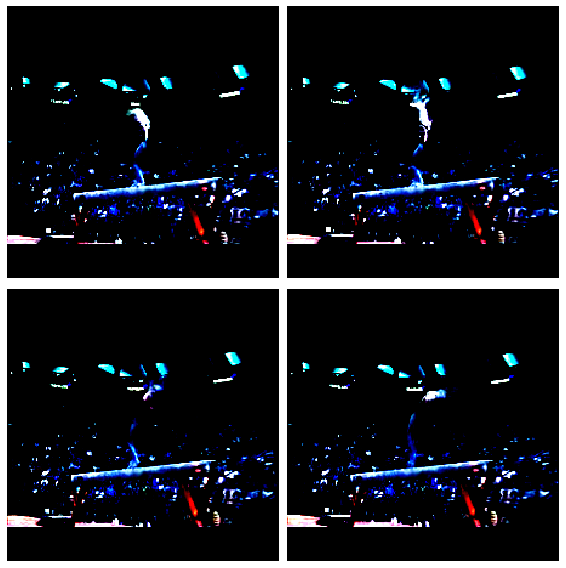

In [ ]:
data[1]

In [ ]:
def sequence_collate(batch):
    try:
        len_batch = len(batch) # original batch length
        batch = list(filter (lambda x:x is not None, batch)) # filter out all the Nones
        batch = list(filter (lambda x: len(x[0])>0, batch))  # filter out all the empty ones.
        batch = torch.utils.data.dataloader.default_collate(batch)
    except Exception as e:    
        import pdb
        pdb.set_trace()
        print(e)

    return batch

In [ ]:
def get_y_func(o):
    if str(o.parents[0]).split('/')[-1] == 'models':
        print(str(o.parents[0]).split('/')[-1]) 
    return str(o.parents[0]).split('/')[-1]

get_y = lambda o:str(o.parents[0]).split('/')[-1]

tfms = get_transforms(do_flip=True, flip_vert=False)

data_path = '../data/UCF101/UCF-101/'
#data_path = '../data/UCF101/UCF-5'

In [ ]:
data = (SequenceList.from_folder(data_path) # Where to find the data? -> in path and its subfolders
        .split_by_fname_file(fname='testlist01.txt', path='../data/UCF101/annotations/ucfTrainTestlist/')             #How to split in train/valid? -> use the folders
        .label_from_func(get_y_func)         # How to label
#        .add_test_folder()                  # Optionally add a test set (here default name is test)
        .transform(tfms, size=224)           # Data augmentation? -> use tfms with a size of 224
        .databunch()) #collate_fn=sequence_collate))    

In [ ]:
# data = (SequenceList.from_folder(data_path) # Where to find the data? -> in path and its subfolders
#         .split_by_fname_file(fname='ucf-5-testlist01.txt', path='../data/UCF101/annotations/ucfTrainTestlist/')             #How to split in train/valid? -> use the folders
#         .label_from_func(get_y_func)         # How to label
# #        .add_test_folder()                  # Optionally add a test set (here default name is test)
#         .transform(tfms, size=224)           # Data augmentation? -> use tfms with a size of 224
#         .databunch()) #collate_fn=sequence_collate))    

In [ ]:
len(data.train_ds.y.classes)

101

In [ ]:
len(data.train_ds.y.classes)

102

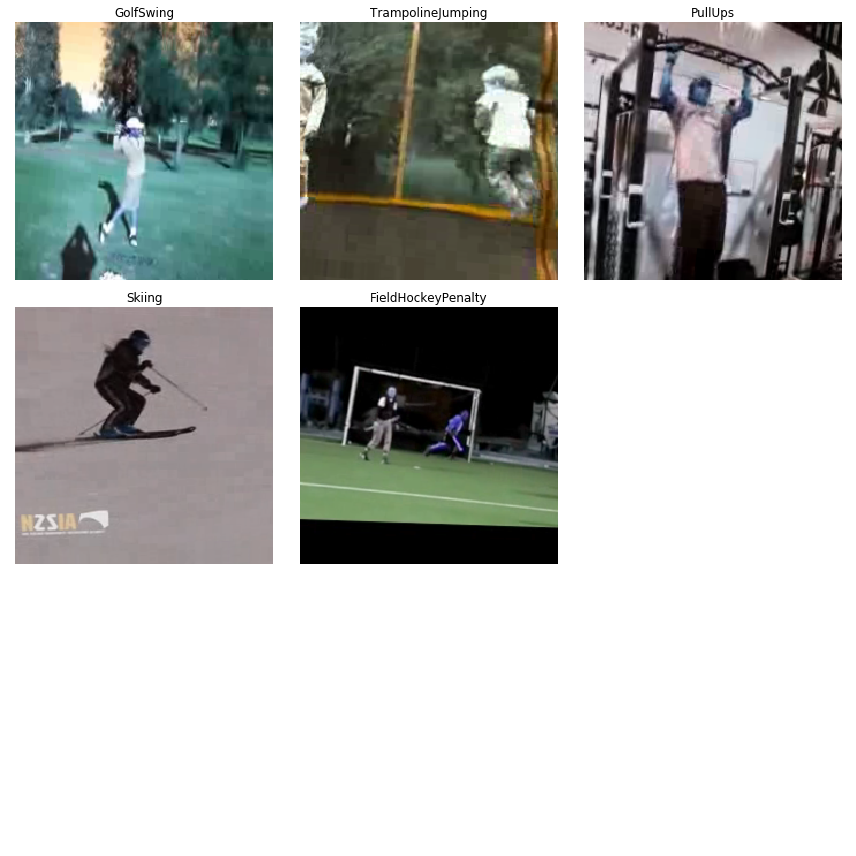

In [ ]:
data.show_batch()

In [ ]:
model =  resnet50(sample_size=224, sample_duration=16)
pretrained = torch.load('./model-pretrained/resnet-50-kinetics.pth', map_location=torch.device('cpu'))

keys = [k for k,v in pretrained['state_dict'].items()]
pretrained_state_dict = {k[7:]: v.cpu() for k, v in pretrained['state_dict'].items()}
model.load_state_dict(pretrained_state_dict)
model.fc = nn.Linear(model.fc.weight.shape[1], 101)

function resnet50


In [ ]:
#model

In [ ]:
loss = nn.CrossEntropyLoss()
learner = Learner(data, model, loss_func=loss, metrics=[accuracy], model_dir='./models')

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


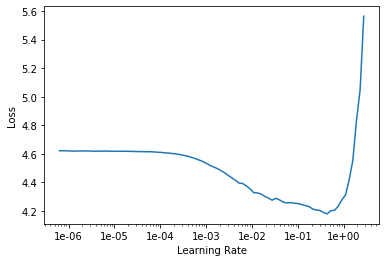

In [ ]:
learner.lr_find()
learner.recorder.plot()

In [ ]:
spectral_norm = nn.utils.spectral_norm
weight_norm = nn.utils.weight_norm

In [ ]:
def conv3d(ni:int, nf:int, ks:int=3, stride:int=1, pad:int=1, norm='batch'):
    bias = not norm == 'batch'
    conv = init_default(nn.Conv3d(ni,nf,ks,stride,pad,bias=bias))
    conv = spectral_norm(conv) if norm == 'spectral' else \
           weight_norm(conv) if norm == 'weight' else conv
    layers = [conv]
    layers += [nn.ReLU(inplace=True)]  # use inplace due to memory constraints
    layers += [nn.BatchNorm3d(nf)] if norm == 'batch' else []
    return nn.Sequential(*layers)

def res3d_block(ni, nf, ks=3, norm='batch', dense=False):
    """ 3d Resnet block of `nf` features """
    return SequentialEx(conv3d(ni, nf, ks, pad=ks//2, norm=norm),
                             conv3d(nf, nf, ks, pad=ks//2, norm=norm),
                             MergeLayer(dense))

In [ ]:
norm = 'batch'
layers = ([res3d_block(1,15,7,norm=norm,dense=True)] +
          [res3d_block(16,16,norm=norm) for _ in range(4)] +
          [conv3d(16,1,ks=1,pad=0,norm=None)])
model = nn.Sequential(*layers)

In [ ]:
loss = nn.MSELoss()
learner = Learner(data, model, loss_func=loss)

In [ ]:
learner.lr_find(num_it=50)
learner.recorder.plot()

In [ ]:
from nbdev.export import *
notebook2script()

Converted 01_dataset_ucf101.ipynb.
Converted 02_avi.ipynb.
Converted 04_data_augmentation.ipynb.
Converted 05_models.ipynb.
Converted 06_models-resnet_3d.ipynb.
Converted 07_utils.ipynb.
Converted 10_run-baseline.ipynb.
Converted 11_run-sequence-convlstm.ipynb.
Converted 12_run-sequence-3d.ipynb.
Converted 14_fastai_sequence.ipynb.
Converted index.ipynb.
